<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos

Al igual que en el notebook de tokenización palabras, aquí también se utilizará el dataset de libros de Horacio Quiroga ("Cuentos de amor, de locura y de muerte").

La idea nuevamente es conservar el notebook original para una mejor comprensión del problema y realizar las modificaciones y pruebas necesarias para el dataset escogido. Además se ensayarán diferentes arquitecturas en la medida que sea posible dados los tiempos de ejecución.

In [ ]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML
import bs4 as bs

In [ ]:
raw_html = urllib.request.urlopen('https://www.textos.info/horacio-quiroga/cuentos-de-amor-de-locura-y-de-muerte/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [ ]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' primavera era el martes de carnaval. nébel acababa de entrar en el corso, ya al\r\noscurecer, y mientras deshacía un paquete de serpentinas, miró al\r\ncarruaje de delante. extrañado de una cara que no había visto la tarde\r\nanterior, preguntó a sus compañeros: —¿quién es? no parece fea. —¡un demonio! es lindísima. creo que sobrina, o cosa así, del doctor\r\n\r\narrizabalaga. llegó ayer, me parece…\n nébel fijó entonces atentamente los ojos en la hermosa criatura. era\r\nuna chica muy joven aún, acaso no más de catorce años, pero\r\ncompletamente núbil. tenía, bajo el cabello muy oscuro, un rostro de\r\nsuprema blancura, de ese blanco mate y raso que es patrimonio\r\nexclusivo de los cutis muy finos. ojos azules, largos, perdiéndose\r\nhacia las sienes en el cerco de sus negras pestañas. acaso un poco\r\nseparados, lo que da, bajo una frente tersa, aire de mucha nobleza o\r\nde gran terquedad. pero sus ojos, así, llenaban aquel semblante en\r\nflor con la luz de su belleza. y al sen

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [ ]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [ ]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [ ]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

66

In [ ]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [ ]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [ ]:
tokenized_text[:100]

[53,
 18,
 38,
 61,
 56,
 30,
 33,
 39,
 38,
 30,
 53,
 39,
 38,
 30,
 53,
 39,
 65,
 53,
 56,
 30,
 38,
 32,
 39,
 60,
 53,
 3,
 39,
 53,
 52,
 30,
 38,
 42,
 30,
 33,
 30,
 65,
 8,
 53,
 42,
 15,
 6,
 39,
 65,
 53,
 30,
 52,
 30,
 6,
 30,
 6,
 30,
 53,
 3,
 39,
 53,
 39,
 42,
 32,
 38,
 30,
 38,
 53,
 39,
 42,
 53,
 39,
 65,
 53,
 52,
 1,
 38,
 60,
 1,
 9,
 53,
 28,
 30,
 53,
 30,
 65,
 23,
 29,
 1,
 60,
 52,
 24,
 38,
 39,
 52,
 39,
 38,
 9,
 53,
 28,
 53,
 56,
 61,
 39,
 42,
 32]

### Organizando y estructurando el dataset

In [ ]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [ ]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [ ]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [ ]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [ ]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
X.shape

(261641, 100)

In [ ]:
X[0,:10]

array([53, 18, 38, 61, 56, 30, 33, 39, 38, 30])

In [ ]:
y[0,:10]

array([18, 38, 61, 56, 30, 33, 39, 38, 30, 53])

In [ ]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [ ]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

Además del modelo propuesto en clase, se crearán dos modelos adicionales tal como se hizo con el notebook de palabras: LSTM y GRU. Debido a que el costo computacional de entrenar estos modelos es bastante elevado se utilizaron menos unidades en las capas LSTM y GRU. Aún así, el notebook debió ser ejecutado en sesiones diferentes, debido a las limitaciones de uso de Colab.

In [ ]:
model_simpleRNN = Sequential()

model_simpleRNN.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_simpleRNN.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_simpleRNN.add(Dense(vocab_size, activation='softmax'))
model_simpleRNN.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_simpleRNN.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, None, 66)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 200)           │          53,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, None, 66)            │          13,266 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,666 (260.41 KB)

 Trainable params: 66,666 (260.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Modelo basado en LSTM
model_LSTM = Sequential()
model_LSTM.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_LSTM.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_LSTM.add(Dense(vocab_size, activation='softmax'))
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_LSTM.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_6 (TimeDistributed) │ (None, None, 66)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 100)           │          66,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, None, 66)            │           6,666 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,466 (286.98 KB)

 Trainable params: 73,466 (286.98 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Modelo basado en GRU
model_GRU = Sequential()
model_GRU.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_GRU.add(GRU(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_GRU.add(Dense(vocab_size, activation='softmax'))
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_GRU.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_5 (TimeDistributed) │ (None, None, 66)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, None, 100)           │          50,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, None, 66)            │           6,666 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,066 (222.91 KB)

 Trainable params: 57,066 (222.91 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

En este caso no fue necesario modificar el cálculo de la perplejidad como en el notebook de tokenización por palabras ya que funcionó adecuadamente.

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_name = model_name

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f'{self.model_name}.keras')
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

En esta sección se entrenarán los modelos propuestos: SimpleRNN, LSTM y GRU. Se utilizarán los datos de entrenamiento y validación preparados en las celdas previas. El entrenamiento se realizará durante 20 épocas o hasta que la métrica Perplejidad deje de mejorar en los datos de validación (utilizando *Early Stopping*).

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl_simpleRNN = []
hist_simpleRNN = model_simpleRNN.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_simpleRNN, model_name='model_simpleRNN')], batch_size=256)

Epoch 1/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 2.5758
 mean perplexity: 7.792677701748081 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 392s 378ms/step - loss: 2.5753
Epoch 2/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 2.0602
 mean perplexity: 6.733710831538418 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 394s 385ms/step - loss: 2.0602
Epoch 3/20
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 1.9411
 mean perplexity: 6.311739803702041 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 387s 378ms/step - loss: 1.9410
Epoch 4/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 1.8806
 mean perplexity: 6.055842828900733 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 437s 374ms/step - loss: 1.8806
Epoch 5/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 1.8454
 mean perplexity: 5.9165701656889125 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 446s 378ms/step - loss: 1.8454
Epoch 6/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - l

In [ ]:
history_ppl_LSTM = []
hist_LSTM = model_LSTM.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_LSTM, model_name='model_LSTM')], batch_size=256)

Epoch 1/20
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 2.8754
 mean perplexity: 9.833282060321125 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 505s 490ms/step - loss: 2.8752
Epoch 2/20
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 2.2985
 mean perplexity: 8.597078627624356 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 464s 453ms/step - loss: 2.2985
Epoch 3/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 2.2044
 mean perplexity: 8.033352041594094 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 507s 458ms/step - loss: 2.2044
Epoch 4/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - loss: 2.1505
 mean perplexity: 7.726981455439921 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 465s 455ms/step - loss: 2.1505
Epoch 5/20
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - loss: 2.1123
 mean perplexity: 7.4291275439393765 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 504s 457ms/step - loss: 2.1123
Epoch 6/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - l

In [ ]:
history_ppl_GRU = []
hist_GRU = model_LSTM.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_GRU, model_name='model_GRU')], batch_size=256)

Epoch 1/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 1.9122
 mean perplexity: 6.132090101063876 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 458s 447ms/step - loss: 1.9122
Epoch 2/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 1.9064
 mean perplexity: 6.076115935236581 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 503s 448ms/step - loss: 1.9064
Epoch 3/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 1.9003
 mean perplexity: 6.062670463962735 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 462s 452ms/step - loss: 1.9003
Epoch 4/20
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - loss: 1.8942
 mean perplexity: 6.030976644710721 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 505s 455ms/step - loss: 1.8942
Epoch 5/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 1.8873
 mean perplexity: 5.98751044848649 

Saved new model!
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 496s 449ms/step - loss: 1.8873
Epoch 6/20
1022/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - los

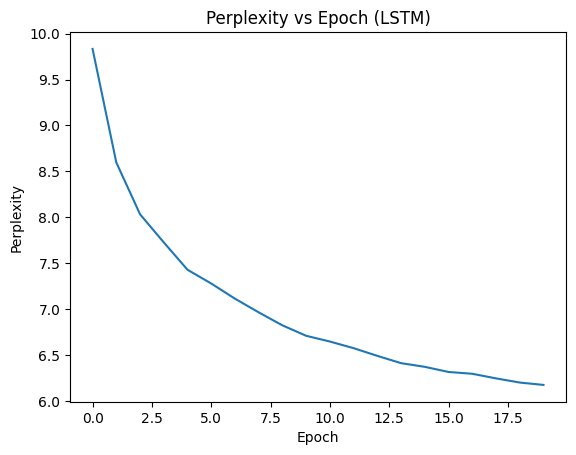

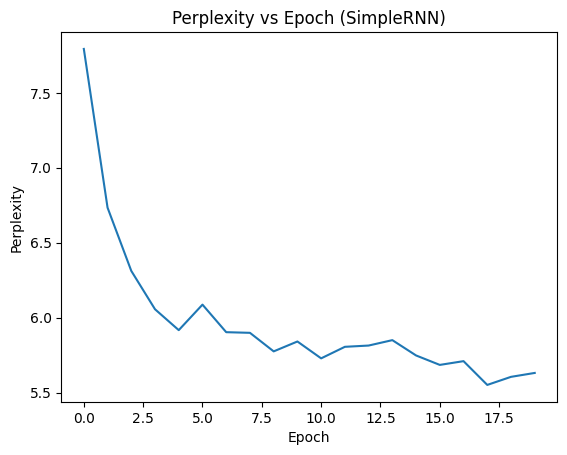

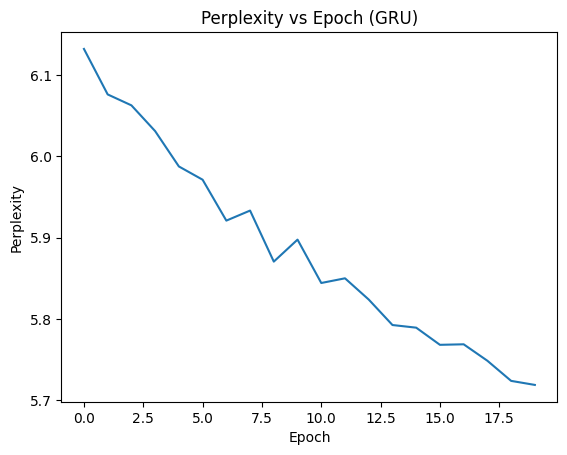

In [ ]:
plt.plot(history_ppl_LSTM)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Epoch (LSTM)')
plt.show()

plt.plot(history_ppl_simpleRNN)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Epoch (SimpleRNN)')
plt.show()

plt.plot(history_ppl_GRU)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Epoch (GRU)')
plt.show()

En los gráficos se puede observar que SimpleRNN llegó a mejores resultados en cuanto a perplejidad. Sin embargo, tanto LSTM como GRU presentan una curva más interesante que podría llegar a mejorar aún más si se agregan épocas o se ajustan hiperparámetros. Recordar que se utilizaron menos unidades recurrentes en estas dos arquitecturas debido a los costos de entrenamiento, por lo cual su potencial puede ser aún mayor.

De todas formas, el modelo SimpleRNN entrenó más rápido que el resto. Esto es debido a que LSTM y GRU son más complejos computacionalmente.

In [ ]:
# Se cargan los mejores modelos guardados
model_LSTM = keras.models.load_model('model_LSTM.keras')
model_simpleRNN = keras.models.load_model('model_simpleRNN.keras')
model_GRU = keras.models.load_model('model_GRU.keras')


### Predicción del próximo caracter

En la siguiente celda se utiliza Gradio para disponer de una interfaz gráfica de pruebas. De todas formas, se harán pruebas manuales para que queden registradas en el notebook.

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [ ]:
import gradio as gr

def model_response(human_text, model=model_simpleRNN):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://8eb1d239f5aba23e12.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8eb1d239f5aba23e12.gradio.live


El siguiente ejemplo predice la siguiente letra en la frase "Era una cas". Las predicciones fueron todas esperables, devolviendo una "a" en cada caso. Notar que no es una obviedad dado que también pudo haber devuelto "caso", lo cual indica que probablemente está considerando correctamente el contexto.

In [ ]:
print(f'Respuesta LSTM: { model_response("Era una cas", model_LSTM) }')
print(f'Respuesta SimpleRNN: {model_response("Era una cas", model_simpleRNN)}')
print(f'Respuesta GRU: {model_response("Era una cas", model_GRU)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Respuesta LSTM: Era una casa
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Respuesta SimpleRNN: Era una casa
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Respuesta GRU: Era una casa


El siguiente caso es interesante ya que también había muchas posibilidades de las cuales eligió "í", que tiene sentido teniendo en cuenta que una de las palabras más probables es "tenía".

In [ ]:
print(f'Respuesta LSTM: { model_response("La casa no ten", model_LSTM) }')
print(f'Respuesta SimpleRNN: {model_response("La casa no ten", model_simpleRNN)}')
print(f'Respuesta GRU: {model_response("La casa no ten", model_GRU)}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Respuesta LSTM: La casa no tení
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Respuesta SimpleRNN: La casa no tení
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Respuesta GRU: La casa no tení


### Generación de secuencias

In [ ]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [ ]:
input_text='El día estaba'

print('Modelo Simple RNN:')
print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))

print('Modelo LSTM:')
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))

print('Modelo GRU:')
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

Modelo Simple RNN:
El día estaba a su cuerpo de un momento de 
Modelo LSTM:
El día estaba en el para en el para en el p
Modelo GRU:
El día estaba a la mara de la caballa de la


Se puede observar en este ejemplo que las secuencias generadas no tienen demasiado sentido. Se generaron palabras no existentes como "mara" y "caballa" en el caso de GRU, y se puede notar que en LSTM las predicciones parecen entrar en loop.

In [ ]:
input_text='El hombre tenía un perro que'

print('Modelo Simple RNN:')
print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))

print('Modelo LSTM:')
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))

print('Modelo GRU:')
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

Modelo Simple RNN:
El hombre tenía un perro que es un momento de la cabeza de
Modelo LSTM:
El hombre tenía un perro que el cama de la mano de la mano
Modelo GRU:
El hombre tenía un perro que estaba a la mara de la caball


Parecido al caso anterior, GRU formó la palabra "mara" que no existe en el texto y nuevamente LSTM parece entrar en un ciclo.

Notar que al final pueden aparecer palabras cortadas, lo cual es normal porque se está tokenizando por caracteres.

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
print(f'model_LSTM (estocástico), temp=1: {decode(beam_search(model_LSTM,num_beams=10,num_words=20,input="durante diez días",temp=1,mode="sto")[0])}')
print(f'model_simpleRNN (estocástico), temp=1: {decode(beam_search(model_simpleRNN,num_beams=10,num_words=20,input="durante diez días",temp=1,mode="sto")[0])}')
print(f'model_GRU (estocástico), temp=1: {decode(beam_search(model_GRU,num_beams=10,num_words=20,input="durante diez días",temp=1,mode="sto")[0])}')


model_LSTM (estocástico), temp=1: durante diez días más esta la cabeza,
model_simpleRNN (estocástico), temp=1: durante diez días de un poco de la ca
model_GRU (estocástico), temp=1: durante diez días de los ojos de sus 


In [ ]:
print(f'model_LSTM (estocástico), temp=5: {decode(beam_search(model_LSTM,num_beams=10,num_words=20,input="durante diez días",temp=5,mode="sto")[0])}')
print(f'model_simpleRNN (estocástico), temp=5: {decode(beam_search(model_simpleRNN,num_beams=10,num_words=20,input="durante diez días",temp=5,mode="sto")[0])}')
print(f'model_GRU (estocástico), temp=5: {decode(beam_search(model_GRU,num_beams=10,num_words=20,input="durante diez días",temp=5,mode="sto")[0])}')

model_LSTM (estocástico), temp=5: durante diez díasa hicápayó.,—¿yuseté
model_simpleRNN (estocástico), temp=5: durante diez díaseta…
cricado la!á-8b
model_GRU (estocástico), temp=5: durante diez días pricia irdefuiral.r


In [ ]:
print(f'model_LSTM (determinista): {decode(beam_search(model_LSTM,num_beams=10,num_words=20,input="durante diez días",mode="det")[0])}')
print(f'model_simpleRNN (determinista): {decode(beam_search(model_simpleRNN,num_beams=10,num_words=20,input="durante diez días",mode="det")[0])}')
print(f'model_GRU (determinista): {decode(beam_search(model_GRU,num_beams=10,num_words=20,input="durante diez días",mode="det")[0])}')

model_LSTM (determinista): durante diez días que no había en el 
model_simpleRNN (determinista): durante diez días de la cabeza de la 
model_GRU (determinista): durante diez días después de los ojos


Las observaciones para los resultados Beam Search son análogos a los del notebook que tokeniza por palabras. Aquí se puede observar que para el caso estocástico a mayor temperatura se ven resultados cada vez más extraños. Estos resultados más diversos resultan en agrupaciones de caracteres que carecen de significado en la lengua española.

En las pruebas con menor temperatura o directamente el caso determinista los resultados no presentaron agrupaciones de caracteres extraños, resultando siempre en palabras existentes separadas por espacios.

### Conclusiones generales

En este notebook se entrenaron modelos de lenguaje basados en redes neuronales recurrentes, en particular sobre un texto en español. Se utilizaron tres arquitecturas diferentes: SimpleRNN, LSTM y GRU, evaluando la métrica de Perplejidad.

Los resultados obtenidos mostraron que SimpleRNN logró la mejor perplejidad, aunque tanto LSTM y GRU presentaron curvas de aprendizaje que sin dudas se pueden mejorar ajustando los hiperparámetros o definiendo más épocas de aprendizaje. Esto último no se hizo debido a los a los tiempos de entrenamiento y las limitaciones de uso de Colab.

Las pruebas mostraron un comportamiento aceptable de las tres arquitecturas, reconociendo patrones básicos como la formación de palabras y la separación con espacios. En algunos casos las palabras generadas no estaban presentes en el texto original, lo cual es un punto a mejorar. En las predicciones con Beam Search estocástico con temperaturas altas fueron donde se presentaron los mayores problemas de generación. De todas formas, teniendo en cuenta que la tokenización es por caracteres, podría considerarse esperable.

Más allá de los resultados obtenidos, una gran enseñanza de este trabajo es la importancia que tienen los recursos computacionales y la optimización del uso de los mismos. Analizar algunas pocas variantes de estas estructuras básicas llevó mucho tiempo de debug, entrenamiento y pruebas, para llegar a un resultado que seguramente no es el mejor. En una situación real, es importante tenerlo en cuenta para considerar utilizar una solución o bien más simple, o partir de algún modelo preentrenado.



